<a href="https://colab.research.google.com/github/JacopoKahl/autoencoder_denoising/blob/main/Autoencoder_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Autoencoder Denoising

Sequential Autoencoder model on the MNIST dataset.

Example of Autoencoder for denoiosing images. The auotencoder is trained on oisy imagesas input and clean ones as output. The model therefore lerans to denoise the training set. The denoise will be strictly dependent on trining images and performance of images very different from the training set is likely to be low. 

##Imports

Import libraries and functions

In [72]:
#Keras imports
from keras.models import Sequential #Sequential model class
from keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape

import numpy as np #numerical library numpy

#Import dataset
from keras.datasets import mnist

#Visualization
import matplotlib.pyplot as plt #visualization library

##Load dataset

In [73]:
#Load train and test data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

##Checking dataset

In [74]:
print('Dimensioni input training set: ', X_train.shape)
print('Dimensioni output training set: ', Y_train.shape)

print('Dimensioni input training set: ', X_test.shape)
print('Dimensioni output training set: ', Y_test.shape)

Dimensioni input training set:  (60000, 28, 28)
Dimensioni output training set:  (60000,)
Dimensioni input training set:  (10000, 28, 28)
Dimensioni output training set:  (10000,)


Label:  4


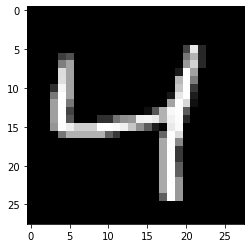

In [75]:
#Peeking into the training set

index = 2

plt.imshow(X_train[index], cmap='gray') #Show input image at index with grayscale colormap
print('Label: ', Y_train[index])

##Pre-processing the dataset

Normalizing and reshaping vectors

In [76]:
X_train = X_train.astype('float32') /255 #casting to float and normalizing input in the [0,1] interval
X_test = X_test.astype('float32') /255 #casting to float and normalizing input in the [0,1] interval

##Add noise 

Create a noisy version of the datasetto be used as input to the autoencoder.

MNIST images will be corrupted by noise with normal distribution with center (mean) in 0.5 and standard deviation (std) 0.5

Try also different settings parameters and see the effects.


In [77]:
#Noise for training images
X_train_noise = np.random.normal(loc=0.5, scale=0.5, size=X_train.shape) #vector of 2D noise (matrix) to be added to train images

#Noise for test images
X_test_noise = np.random.normal(loc=0.5, scale=0.5, size=X_test.shape) #vector of 2D noise (matrix) to be added to train images

print('Train noise dimensione: ', X_train_noise.shape)
print('Test noise dimensione: ', X_test_noise.shape)

Train noise dimensione:  (60000, 28, 28)
Test noise dimensione:  (10000, 28, 28)


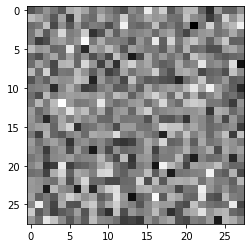

In [78]:
#Visualize the first train noise image
index = 0
plt.imshow(X_train_noise[index], cmap='gray')

In [79]:
#Adding noise to train and test images

X_train_noisy = X_train + X_train_noise #noisy train images
X_test_noisy = X_test + X_test_noise #noisy test images

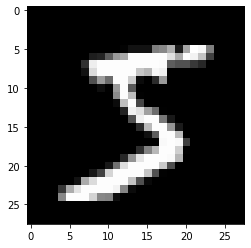

In [80]:
#SHow original image
index_train = 0

plt.imshow(X_train[index], cmap='gray')

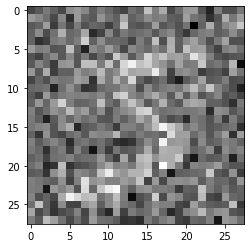

In [81]:
#Visualize the first train noisy image
index_train = 0

plt.imshow(X_train_noisy[index], cmap='gray')

Normalization in the [0,1] interval is surely lost after dding noise, so we need to restore values in that interval, this time by clipping

In [82]:
X_train_noisy = np.clip(X_train_noisy, 0. , 1. ) #overwriting noisy training setwith clipped values 
X_test_noisy = np.clip(X_test_noisy, 0. , 1. ) #overwriting noisy test setwith clipped values

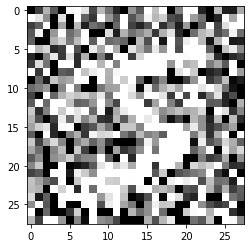

In [83]:
#Visualize the first train noisy image
index_train = 0

plt.imshow(X_train_noisy[index], cmap='gray')

##Autoencoder model

###Network structure

In [84]:
inShape = X_train_noisy.shape[1:] + (1,) #adding channel info
print('Input shape: ', inShape)

latent_dim = 2 #Latent space dimension: 2D is easy to visualize, for better reconstruction performance try 16 or greater

Input shape:  (28, 28, 1)


## Encoder

Encoder network that creates representation in the latent space for input images.

In [85]:
encoder = Sequential() #instance of the Sequential class

encoder.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape= inShape))
encoder.add(Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'))
encoder.add(Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'))
encoder.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))

encShapeBeforeFlatten = encoder.output_shape[1:] #save dimensions of output feature map before flattening
print('Encoder output shape before flatten: ', encShapeBeforeFlatten)

encoder.add(Flatten()) #flatten 2D output from previous layer into a 1D array

encoder.add(Dense(units=latent_dim, name='Latent_vector')) #NO activation!

encoder.summary()

Encoder output shape before flatten:  (7, 7, 64)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
Latent_vector (Dense)        (None, 2)                 6274      
Total params: 98,946
Trainable params: 98,946
Non-trainable params: 0


##Decoder

The deoder network reconstructs an image from vector in latent space.

In [86]:
decoder = Sequential()

decoder.add(Dense(units=np.prod(encShapeBeforeFlatten), input_dim=latent_dim)) 
decoder.add(Reshape(encShapeBeforeFlatten)) #reshape input into encShapeBeforeFlatten resolution
decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(filters=1, kernel_size=3, strides=1, activation='sigmoid', padding='same'))

print(decoder.output_shape)
decoder.summary()

(None, 28, 28, 1)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 28, 28, 1)         289       
Total params: 102,017
Trainable params: 102,017
Non-trainable params: 0
_____________________________

##Autoencoder

In [87]:
autoencoder = Sequential()

autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_10 (Sequential)   (None, 2)                 98946     
_________________________________________________________________
sequential_11 (Sequential)   (None, 28, 28, 1)         102017    
Total params: 200,963
Trainable params: 200,963
Non-trainable params: 0
_________________________________________________________________


In [88]:
#Specify loss function and optimizer
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

##Training process

In [89]:
#Check train and test dimension

print(X_train_noisy.shape)
print(X_test_noisy.shape)

#input dimensions
train_input_dim = X_train_noisy.shape + (1,)
test_input_dim = X_test_noisy.shape + (1,)

#Reshaping train and test sets
X_train_noisy = np.reshape(X_train_noisy, train_input_dim)
X_test_noisy = np.reshape(X_test_noisy, test_input_dim)

print(X_train_noisy.shape)
print(X_test_noisy.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [90]:
autoencoder.fit(X_train_noisy, X_train, epochs=10, batch_size=32, validation_data=(X_test_noisy, X_test))

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2308 - val_loss: 0.2059
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2013 - val_loss: 0.1976
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1959 - val_loss: 0.1936
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1928 - val_loss: 0.1922
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1908 - val_loss: 0.1900
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1893 - val_loss: 0.1897
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1882 - val_loss: 0.1899
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1872 - val_loss: 0.1886
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1863 - val_loss: 0.1874
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.185

##Visualization

In [ ]:
#Generate output images corresponding to test input images

decodedImages = autoencoder.predict(X_test)

print(decodedImages.shape)

(10000, 28, 28, 1)


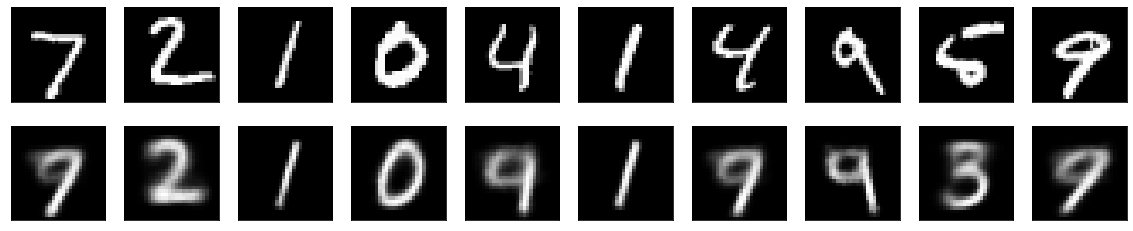

In [ ]:
#The following coder plots a figure made of 10 images per row on two rows

n = 10 #number of subfigures per row

plt.figure(figsize=(20,4)) #total figure size in inches

for i in range(n): #for i in the range [0, n]
  #display original test images
  ax = plt.subplot(2, n, i+1) #create placeholder for the i-th image (plt works with index starting with 1 not 0)
  plt.imshow(X_test[i].reshape(28,28), cmap='gray') #show i-th image
  ax.get_xaxis().set_visible(False) #disable x axis visibility
  ax.get_yaxis().set_visible(False) #disable y axis visibility

  #display reconstructed test images
  ax = plt.subplot(2, n, i+1+n) #create placeholder for the i-th image (plt works with index starting with 1 not 0)
  plt.imshow(decodedImages[i].reshape(28,28), cmap='gray') #show i-th image
  ax.get_xaxis().set_visible(False) #disable x axis visibility
  ax.get_yaxis().set_visible(False) #disable y axis visibility

plt.show() #display entire image

##Show the latent space

Visualize the 2D vectors (points in a 2D space) generated by the encoder to represent test images.

In [ ]:
X_test_encoded = encoder.predict(X_test) #create encoded vectors (embeddings) for input images using only the encoder model

print(X_test_encoded.shape)

(10000, 2)


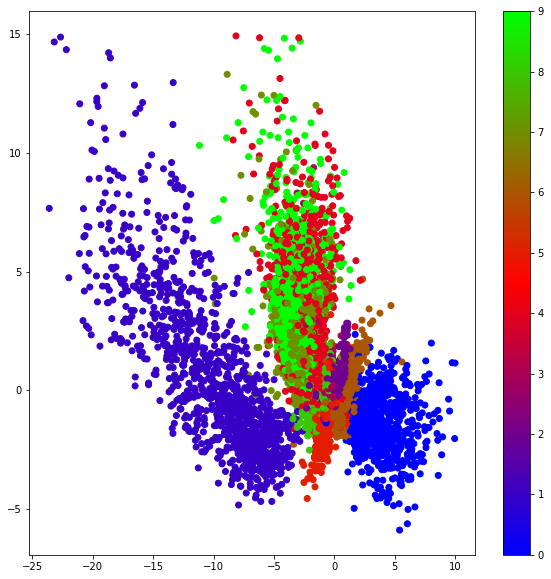

In [ ]:
plt.figure(figsize=(10,10)) #figure of 10 inches
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test, cmap='brg') #scatter plot of embeddings of test images
plt.colorbar()
plt.show()

##Sampling from the latent space to generate new digit

To sample from the latent space let's compute min and max values of encoded training samples.

In [ ]:
#Generate embeddings for training input images
X_train_encoded = encoder.predict(X_train)

In [ ]:
(lx_max, ly_max)= np.amax(X_train_encoded, axis=0) #max x and y values in the latent space
(lx_min, ly_min)= np.amin(X_train_encoded, axis=0) #min x and y values in the latent space

print('Max x: ', lx_max)
print('Min x: ', lx_min)
print('Max y: ', ly_max)
print('Min y: ', ly_min)

Max x:  11.87346
Min x:  -24.86868
Max y:  15.967457
Min y:  -5.894373


Let's perform uniform sampling in the 2D latent space with the above bounds

In [ ]:
sampleX = np.random.uniform(lx_min, lx_max)
sampleY = np.random.uniform(ly_min, ly_max)

print('Sampled vector: ', sampleX, sampleY)

Sampled vector:  2.4308475483937677 10.21244528078546


In [ ]:
#Create array as input to the decoder
sample = np.array([sampleX, sampleY])
print(sample.shape)

sample = np.reshape (sample, (1,)+sample.shape)
print(sample.shape)

#Decode sample vector

decodedSample = decoder.predict(sample)
print(decodedSample.shape)

(2,)
(1, 2)
(1, 28, 28, 1)


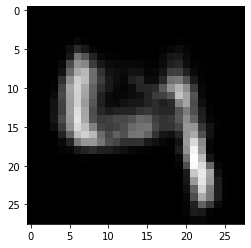

In [ ]:
plt.imshow(decodedSample.reshape(28,28), cmap='gray')